In [3]:
import numpy as np
import pywt
from scipy.signal import filtfilt, butter, iirnotch, lfilter, medfilt, cheby2
from statistics import median, mean, variance
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-paper')


Cargamos una señal de ECG y la normalizamos restando su media y dividiendo por su pico máximo

In [4]:
# Load ECG signal

ecg_signal = np.loadtxt('118e00.csv')

def normalize_signal(signal):
    mean_amplitude = np.mean(np.abs(signal))
    normalized_signal = signal / mean_amplitude
    return normalized_signal

ecg_signal = ecg_signal[:20000]
ecg_signal = ecg_signal-mean(ecg_signal)
ecg_signal = normalize_signal(ecg_signal)

Creamos las funciones para graficar un escalograma de la DWT de una señal

In [5]:

def create_scalogram(coefficients):
        num_levels = len(coefficients)
        max_length = max(len(c) for c in coefficients)
        scalogram = np.zeros((num_levels, max_length))

        for i, c in enumerate([abs(x) for x in coefficients]):
            length = max_length // len(c)  # Adjust the length based on level
            stretched_c = np.repeat(c, length)[:max_length]
            scalogram[i, :len(stretched_c)] = stretched_c

        return scalogram

def print_scalogram(ecg_signal, level=9, wavelet = 'db4'):

    coeffs = pywt.wavedec(ecg_signal-mean(ecg_signal), wavelet, level=level)
    # Create the scalogram
    scalogram = create_scalogram(coeffs)

    # Plot the scalogram
    plt.imshow(scalogram, aspect='auto', cmap='jet', interpolation='nearest')
    plt.xlabel('Time (s)')
    plt.ylabel('Scale')
    plt.colorbar(label='Coefficient')
    plt.title('Scalogram')

    # Add white lines between arrays
    for i in range(1, len(coeffs)):
        plt.axhline(i - 0.5, color='white', linewidth=0.5)
    num_columns = scalogram.shape[1]


    num_samples = np.max([len(x) for x in coeffs]) # Assuming you have a data array

    total_time = len(ecg_signal)/360  # Desired total time in seconds
    num_ticks = 4  # Total number of ticks

    tick_spacing = num_samples // num_ticks  # Integer division to get the approximate tick spacing

    # Generate x-axis values based on tick spacing
    x_ticks = [i * tick_spacing for i in range(num_ticks)]

    # Convert x-axis values to time values
    x_tick_labels = [f'{x / num_samples * total_time:.2f}' for x in x_ticks]

    # Set x-axis ticks and labels
    plt.xticks(x_ticks, x_tick_labels)

    plt.show()

Ploteamos una FFT de la señal

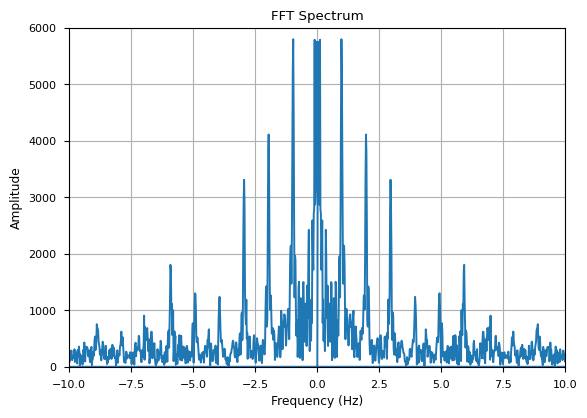

In [90]:

def plot_fft(signal, sample_rate, lim):
    # Compute the FFT
    fft = np.fft.fft(signal)
    
    # Compute the frequency bins
    freq_bins = np.fft.fftfreq(len(signal), 1/sample_rate)
    
    # Take the absolute value of the FFT output
    spectrum = np.abs(fft)
    
    # Plot the spectrum
    plt.figure()
    plt.plot(freq_bins, spectrum)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.title('FFT Spectrum')
    plt.grid(True)
    plt.ylim(0,10000)
    plt.xlim(-lim, lim)
    plt.ylim(0,6000)
    plt.show()

plot_fft(ecg_signal, 360, 10)


Graficamos el ECG y analizamos las separacionesentre zonas con morfología muy distinta 

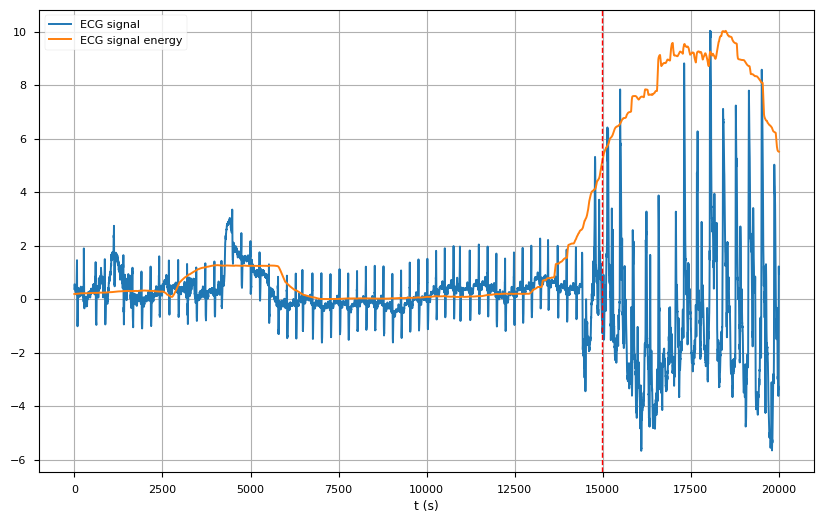

[array([ 0.38395159,  0.40335514,  0.43246047, ..., -0.1447951 ,
       -0.19815486, -0.24181284]), array([-0.27576905, -0.38248857, -0.4843572 , ...,  1.18919885,
        1.10188288,  0.94180361])]


In [97]:
def redistribute_values(bounds, minval):
    lst = []
    for i in range(len(bounds)):
        if i == 0:
            lst.append(bounds[i])
        else:
            lst.append(bounds[i]-bounds[i-1])
    i = 0

    while i < len(lst):
        if lst[i] < minval:
            if i == 0:
                lst[1] += lst[0]
                lst.pop(i)
                bounds.pop(0)
            elif i == len(lst) - 1:
                lst[i-1] += lst[i]
                lst.pop(i)
                bounds.pop(i)
                i -= 1
            else:
                if lst[i-1] <= lst[i+1]:
                    lst[i-1] += lst[i]
                    lst.pop(i)
                    bounds.pop(i-1)
                    i -= 1
                else:
                    lst[i+1] += lst[i]
                    lst.pop(i)
                    bounds.pop(i)
        else:
            i += 1
    bounds.pop(-1)
    return bounds

def energy_based_segmentation(ecg_signal, window_length, threshold, minlen=1000):

    squared_signal = ecg_signal**2
    energy = np.convolve(squared_signal, np.ones(window_length)/window_length, mode='same')
    

    normalized_energy = (energy - np.min(energy)) / (np.max(energy) - np.min(energy))
    

    section_boundaries = np.where(normalized_energy > threshold)[0]
    

    refined_boundaries = [section_boundaries[0]]
    for i in range(1, len(section_boundaries)):
        if section_boundaries[i] - section_boundaries[i-1] > 1:
            refined_boundaries.extend([section_boundaries[i-1], section_boundaries[i]])
    refined_boundaries.append(section_boundaries[-1])
    

    refined_boundaries2 = redistribute_values(refined_boundaries, minlen)
    return refined_boundaries2, normalized_energy


ecg_signal = ecg_signal
window_length = 3000
threshold = 0.5

segment_boundaries, energy = energy_based_segmentation(ecg_signal, window_length, threshold)

# Plot the segmented ECG
t = np.linspace(0, len(ecg_signal)/360, len(ecg_signal))
plt.figure(figsize=(10, 6))
plt.plot(ecg_signal, label='ECG signal')
plt.plot(np.max(abs(ecg_signal))*energy, label='ECG signal energy')

# Plot segment boundaries
for boundary in segment_boundaries:
    plt.axvline(boundary, color='red', linestyle='--', linewidth=1)
    
plt.xlabel('t (s)')
plt.legend()
plt.grid()
plt.show()

segments = []
start_index = 0
for index in segment_boundaries:
    segment = ecg_signal[start_index:index]
    segments.append(segment)
    start_index = index
# Add the remaining elements after the last index
last_segment = ecg_signal[start_index:]
segments.append(last_segment)

print(segments)


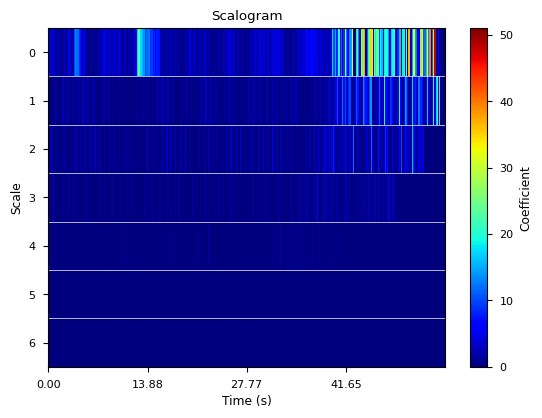

In [81]:
print_scalogram(ecg_signal, level=6)

Creamos las funciones para aplicar un filtrado por DWT

In [30]:
def wav_filter_lvl9(signal,wavelet = 'db4'):

    level = 9


    coeffs = pywt.wavedec(signal, wavelet, level=level)
    new_coeffs = []
    for id, coef in enumerate(coeffs):

        if id == 4 or id == 5:
            ncoef = pywt.threshold(np.array(coef), 0.2*mean(abs(coef)), 'soft')
            new_coeffs.append(np.array(ncoef))
        elif id==6:
            ncoef = pywt.threshold(np.array(coef), mean(abs(coef)), 'soft')
            new_coeffs.append(np.array(ncoef))
        else: 
            new_coeffs.append(np.zeros(len(coef)))

    ecg_filtered = pywt.waverec(new_coeffs, wavelet)
    return ecg_filtered

def wav_filter_lvl9_v2(signal,wavelet = 'db4'):

    level = 9


    coeffs = pywt.wavedec(signal, wavelet, level=level)
    new_coeffs = []
    for id, coef in enumerate(coeffs):

        if id == 4 or id == 5:
            ncoef = pywt.threshold(np.array(coef), 0.1*np.max(abs(coef)), 'hard')
            new_coeffs.append(np.array(ncoef))
        elif id==6:
            ncoef = pywt.threshold(np.array(coef), 0.5*np.max(abs(coef)), 'hard')
            new_coeffs.append(np.array(ncoef))
        else: 
            new_coeffs.append(np.zeros(len(coef)))

    ecg_filtered = pywt.waverec(new_coeffs, wavelet)
    return ecg_filtered

In [58]:
def wav_filter_lvl6(signal,wavelet = 'db4'):


    level = 6


    coeffs = pywt.wavedec(signal, wavelet, level=level)
    new_coeffs = []
    for id, coef in enumerate(coeffs):

        if id==2 or id ==1:
            ncoef = pywt.threshold(np.array(coef), 0.1*mean(abs(coef)), 'hard')
            new_coeffs.append(np.array(ncoef))
        elif id ==3:
            ncoef = pywt.threshold(np.array(coef), 0.5*mean(abs(coef)), 'hard')
            new_coeffs.append(np.array(ncoef))
        else: 
            new_coeffs.append(np.zeros(len(coef)))

    ecg_filtered = pywt.waverec(new_coeffs, wavelet)
    return ecg_filtered

def wav_filter_lvl6_v2(signal,wavelet = 'db4'):


    level = 6


    coeffs = pywt.wavedec(signal, wavelet, level=level)
    new_coeffs = []
    for id, coef in enumerate(coeffs):

        if id==2 or id ==1:
            ncoef = pywt.threshold(np.array(coef), 0.1*np.max(abs(coef)), 'hard')
            new_coeffs.append(np.array(ncoef))
        elif id ==3 or id==4:
            ncoef = pywt.threshold(np.array(coef), 0.1*np.max(abs(coef)), 'hard')
            new_coeffs.append(np.array(ncoef))

        else: 
            new_coeffs.append(np.zeros(len(coef)))

    ecg_filtered = pywt.waverec(new_coeffs, wavelet)
    return ecg_filtered

def wav_filter_lvl6_v3(signal,wavelet = 'db4'):


    level = 6


    coeffs = pywt.wavedec(signal, wavelet, level=level)
    new_coeffs = []
    for id, coef in enumerate(coeffs):

        if id==2 or id ==1 or id==3:
            new_coeffs.append(np.array(coef))
        else: 
            new_coeffs.append(np.zeros(len(coef)))

    ecg_filtered = pywt.waverec(new_coeffs, wavelet)
    return ecg_filtered

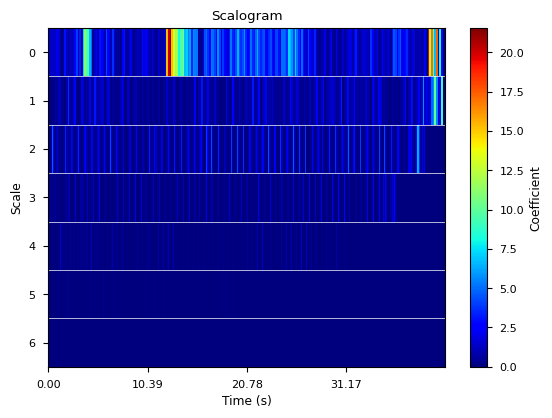

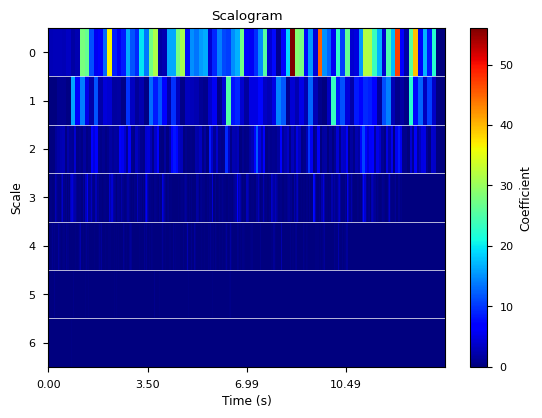

In [84]:
print_scalogram(segments[0], level=6)
print_scalogram(segments[1], level=6)

In [36]:
seg1 = segments[1]
t = np.linspace(0, len(seg1)/360, len(seg1))
plt.plot(t, seg1, label='original')
plt.plot(t, (wav_filter_lvl6_v2(seg1, 'db4')), label='filtered wavelet 6lvls db4')
#plt.plot(t, (wav_filter_lvl9(seg1, 'db4')), label='filtered wavelet 9lvls db4')

plt.grid()
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

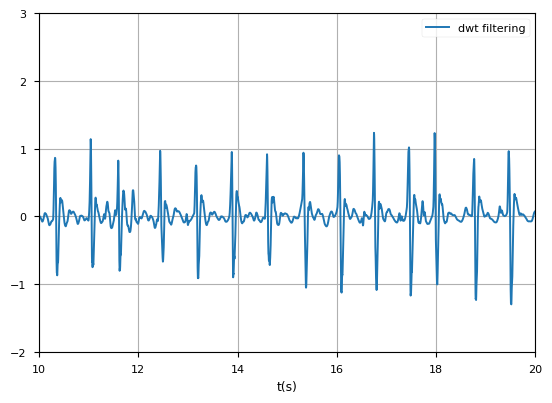

In [80]:
filtered_signal_classic = moving_average_filter(notch_filter(lowpass_filter(ecg_signal), Fnotch=60), 8)
#plt.plot(t, filtered_signal_classic, label='classic filtering')

#plt.plot(t, ecg_signal, label='original ecg')
plt.plot(t, total_ecg, label='dwt filtering')
plt.legend()
plt.xlabel('t(s)')
plt.xlim(10,20)
plt.ylim(-2,3)
plt.grid()
plt.savefig('dwt4')
plt.show()

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import iirnotch, filtfilt, butter

#IIR notch


def notch_filter(signal, Fs = 360, Fnotch = 0.67, BW = 5, Apass = 1 ):
    b, a = iirnotch(Fnotch / (Fs / 2), BW / (Fs / 2), Apass)
    return filtfilt(b, a, signal)

#LP

def lowpass_filter(signal, cutoff_freq= 0.667, fs = 360, N = 6):

    # Design the Butterworth high-pass filter
    Wn = cutoff_freq / (fs / 2)
    b, a = butter(N, Wn, btype='high')
    return filtfilt(b, a, signal)

#MA ventana de 8

def moving_average_filter(signal, window_size):
    # Define the filter coefficients as a window of ones
    filter_coefficients = np.ones(window_size) / window_size

    # Apply the filter using convolution
    filtered_signal = np.convolve(signal, filter_coefficients, mode='same')

    return filtered_signal





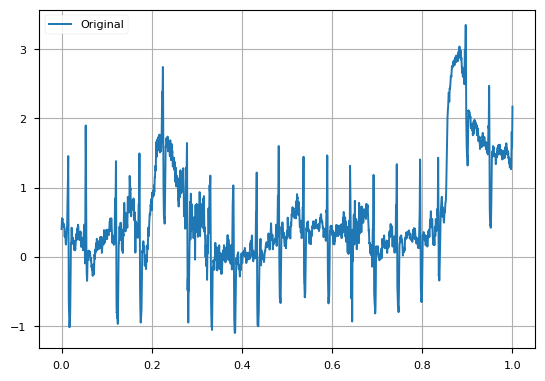

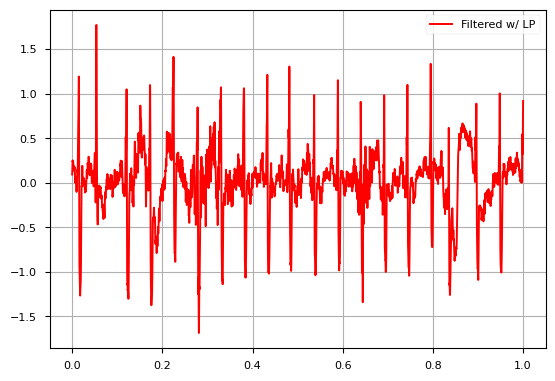

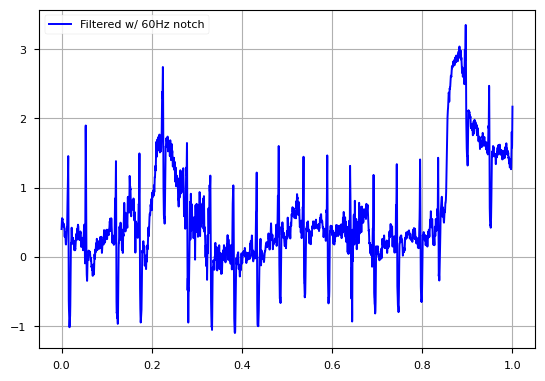

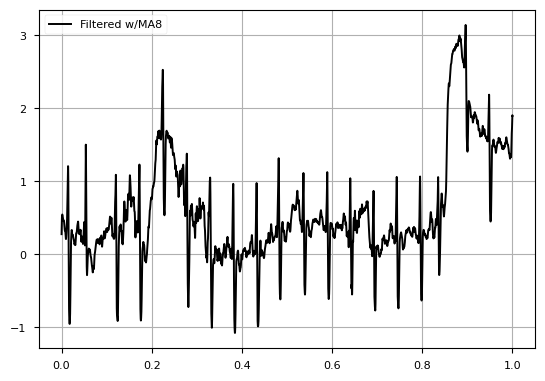

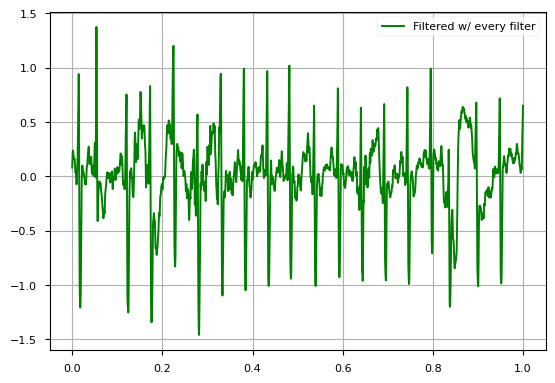

In [95]:
ecg_signal3 = lowpass_filter(ecg_signal)
ecg_signal4 = notch_filter(ecg_signal, Fnotch=60)
ecg_signal5 = notch_filter(ecg_signal, Fnotch=50)
ecg_signal6 = moving_average_filter(ecg_signal, 8)
ecg_signal7 =  moving_average_filter(notch_filter(lowpass_filter(ecg_signal), Fnotch=60), 8)


x1 = 1
x2 = 5000
t = np.linspace(0, 1, x2-x1)
plt.plot(t, ecg_signal[x1:x2], label='Original')
plt.grid()
plt.legend()
plt.show()
plt.plot(t, ecg_signal3[x1:x2], 'r', label='Filtered w/ LP')
plt.grid()
plt.legend()
plt.show()
plt.plot(t, ecg_signal4[x1:x2], 'b', label='Filtered w/ 60Hz notch')
plt.grid()
plt.legend()
plt.show()
plt.plot(t, ecg_signal6[x1:x2], 'k', label='Filtered w/MA8')
plt.grid()
plt.legend()
plt.show()
plt.plot(t, ecg_signal7[x1:x2], 'g', label='Filtered w/ every filter')
plt.grid()
plt.legend()
plt.show()

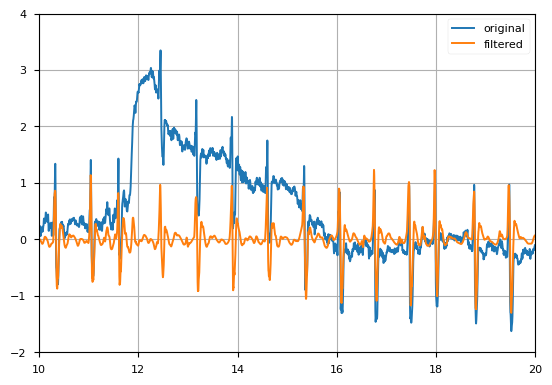

In [62]:
segments2=[]
for i in range(len(segments)):
    segments2.append(wav_filter_lvl6(segments[i], 'db4'))

total_ecg = np.concatenate(segments2, axis=0)

t = np.linspace(0, len(total_ecg)/360, len(total_ecg))

plt.plot(t, ecg_signal, label='original')
plt.plot(t, total_ecg, label='filtered')
plt.xlim(10,20)
plt.ylim(-2,4)
plt.grid()
plt.legend()
plt.show()

OTROS ECGs

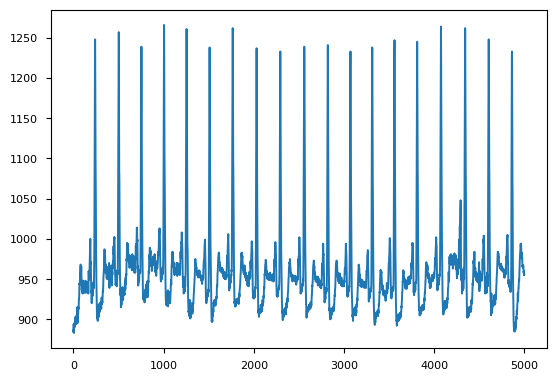

In [113]:
# Load ECG signal
ecg_record = pd.read_csv('./hr/mitbih_database/105.csv')
ecg_record = np.array(ecg_record["'MLII'"])[300000:305000]

plt.plot(ecg_record)

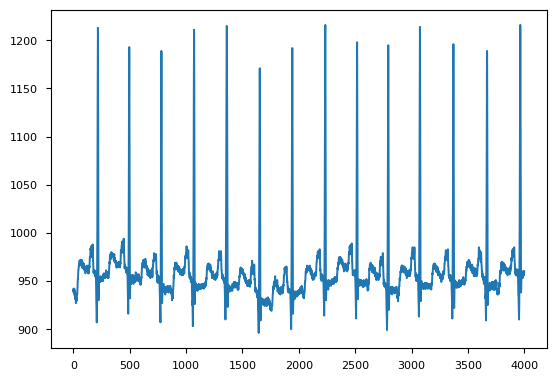

In [109]:
import pandas as pd
ecg_record2 = pd.read_csv('./hr/mitbih_database/100.csv')

plt.plot(np.array(ecg_record2["'MLII'"])[100000:104000])